In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/Shareddrives/SI650_Final_Project/ZhihuRec-1M/answer.csv', index_col = 0)
df.head(5)

,answerID,questionID,is_anonymous,authorID,is_hi_val,is_editor_recom,creat_ts,has_pic,has_vid,n_thanks,n_likes,n_comments,n_collections,n_dislikes,n_reports,n_helpless,tokenID,topicID
0,0,0.0,0,0.0,1,0,1521906876,0,1,1282,9073,684,6277,146,0,40,0 1 2 3 4 5 3 6 7 8 9 1 10 11 12 13 14 15 16 1...,5022 8177 17842 12585
1,1,1.0,0,1.0,0,0,1524045330,1,0,607,10160,539,813,53,0,18,165 166 67 166 167 166 167 168 166 169 166 170...,1604
2,2,2.0,0,2.0,0,0,1525614098,0,0,323,5275,217,144,111,0,23,14 616 14 617 618 16 619 620 166 621 16 622 62...,1682 2 8881 2743
3,3,3.0,0,3.0,0,0,1524290077,1,0,179,3455,397,153,26,0,5,920 921 638 922 499 923 559 51 490 695 491 338...,1578 363 11413 719
4,4,4.0,0,4.0,0,0,1519184507,1,0,1325,25774,962,993,588,0,92,942 943 194 188 944 490 766 945 946 348 483 14...,2 5 3073 4 325


### Timestamp

In [4]:
from datetime import datetime

In [5]:
ts = df.creat_ts.apply(datetime.fromtimestamp)
# Drop invalid records with no timestamp
df = df.drop(df.iloc[ts[ts<"1980-01-01"].index,:].index)
date = ts.apply(datetime.date)

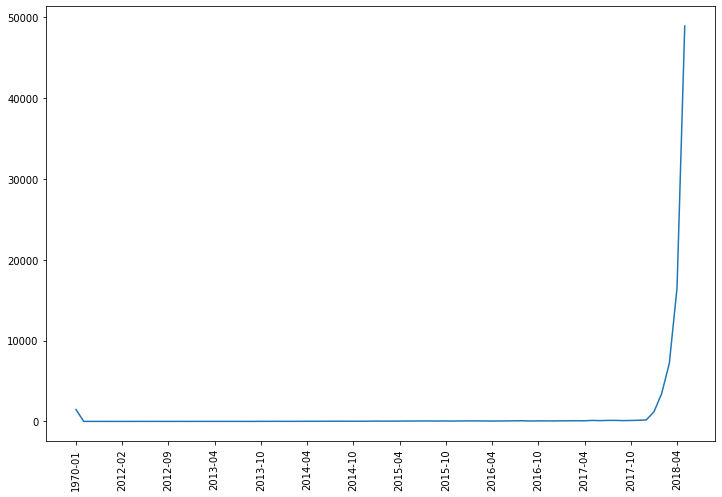

In [6]:
from matplotlib.pyplot import MultipleLocator

plt.figure(figsize=[12,8])
plt.plot(date.apply(lambda x: x.strftime("%Y-%m")).sort_values().unique(), date.apply(lambda x: x.strftime("%Y-%m")).sort_values().value_counts().sort_index())
plt.xticks(rotation=90)
ax=plt.gca()
x_major_locator=MultipleLocator(6)
ax.xaxis.set_major_locator(x_major_locator)

In [7]:
date.apply(lambda x: x.strftime("%Y-%m")).sort_values().value_counts().sort_index()

1970-01     1466
2011-04        3
2011-05        2
2011-07        2
2011-12        3
           ...  
2018-01     1180
2018-02     3424
2018-03     7181
2018-04    16518
2018-05    48886
Name: creat_ts, Length: 80, dtype: int64

### Basic Features

In [ ]:
BASIC_FEATURE = ["n_likes", "n_comments", "n_collections"]

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Distribution of Basic Features of Answers')

<Figure size 1440x1080 with 0 Axes>

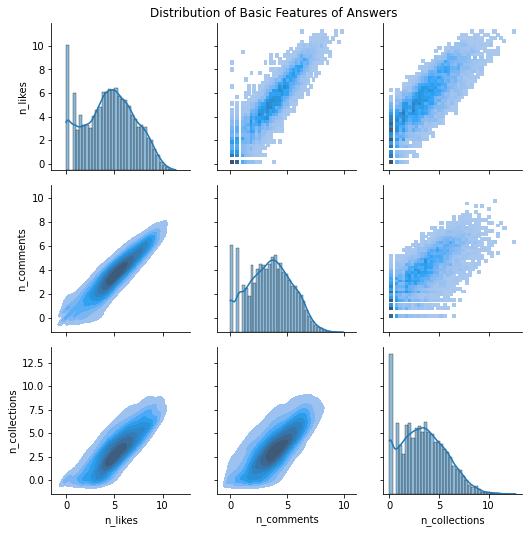

In [ ]:
# random sample to save generating time
# use log to rescale the y axis
plt.figure(figsize=[20,15])
plot_basic = sns.PairGrid(df[BASIC_FEATURE].apply(lambda x: np.log(x)).sample(frac=0.2, random_state=650)) 
plot_basic.map_upper(sns.histplot)
plot_basic.map_lower(sns.kdeplot, fill=True)
plot_basic.map_diag(sns.histplot, kde=True)

#add overall title
plot_basic.fig.subplots_adjust(top=.95)
plot_basic.fig.suptitle('Distribution of Basic Features of Answers')

### Correlation

In [ ]:
# Drop invalid data with no tokenID
df = df.drop(df[df['tokenID'].str.split(' ').str.len().isna() == True].index)

In [ ]:
# Add a column to record the number of tokens
df['n_tokens'] = df['tokenID'].str.split(' ').str.len()

In [ ]:
cols = ['is_anonymous', 'is_hi_val',
       'is_editor_recom', 'has_pic', 'has_vid', 'n_thanks',
       'n_likes', 'n_comments', 'n_collections', 'n_dislikes', 
        'n_reports', 'n_helpless', 'n_tokens']

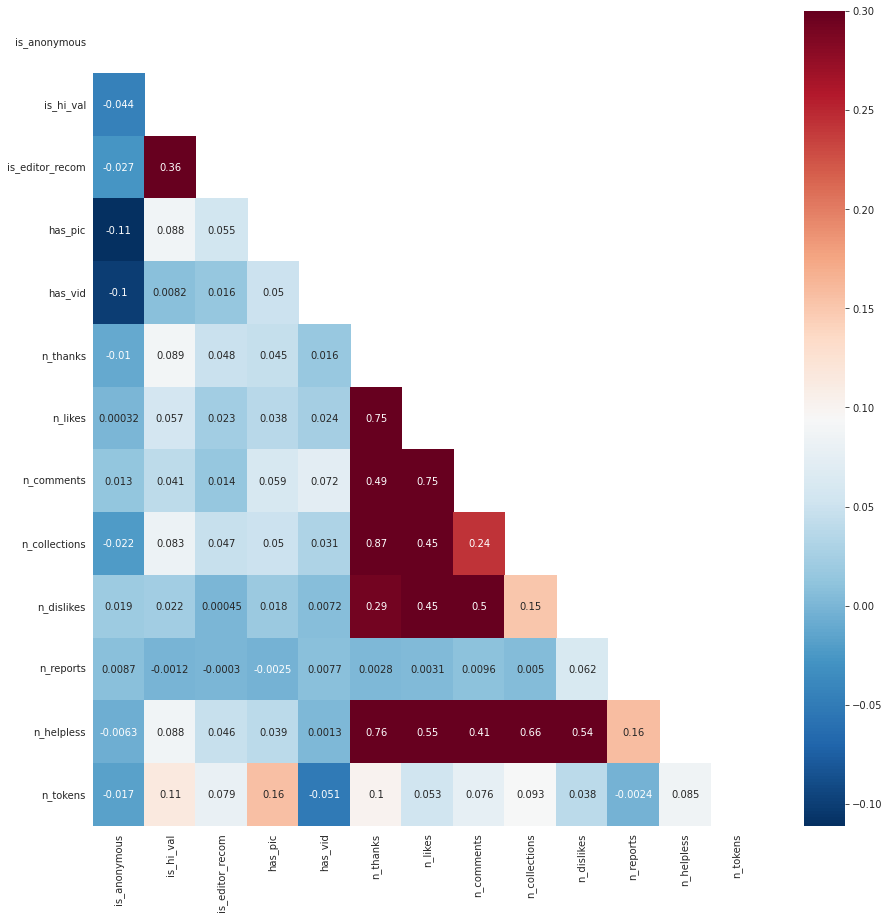

In [ ]:
corr = np.corrcoef(df[cols],rowvar=False) 
corr = pd.DataFrame(corr, columns=cols, index=cols)
# Only show the area below the diag
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmax=0.3, annot=True,cmap="RdBu_r")

### Topics

In [ ]:
# Number of NAN values
len(df[df['topicID'].str.split(' ').str.len().isna() == True])

14362

In [ ]:
# Drop invalid data with no topicID
df = df.drop(df[df['topicID'].str.split(' ').str.len().isna() == True].index)

In [ ]:
# Add a column to record the number of topics
df['n_topics'] = df['topicID'].str.split(' ').str.len()

In [ ]:
freq_series = df.n_topics.value_counts().sort_index()

In [ ]:
freq_series

1      5302
2      6984
3     11182
4     13683
5     28469
6        34
7        25
8         7
9         1
10        1
11        2
Name: n_topics, dtype: int64

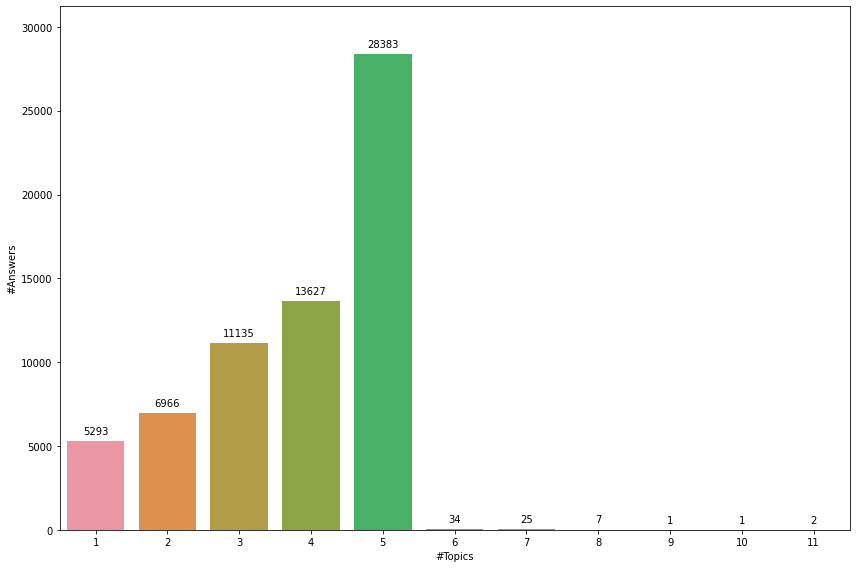

In [ ]:
# plot data
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=freq_series.index, y=freq_series, ax=ax)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

ax.set_xlabel("#Topics")
ax.set_ylabel("#Answers")

ax.margins(y=0.1)
plt.tight_layout()

Text(0, 0.5, '# Answers')

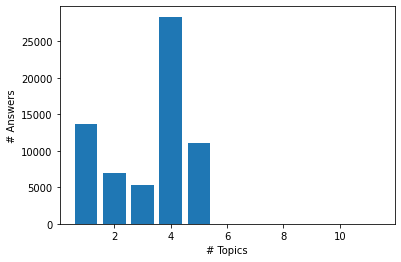

In [ ]:
plt.bar(df.n_topics.unique(), df.n_topics.value_counts())
plt.xlabel("# Topics")
plt.ylabel("# Answers")